# Measuring of Rulesets

This notebook will define functions to generate a simple float dataset and labels for clustering.
It will then test AntClust on these sets.
The clustering performance is evaluated (scored) via the Adjusted Rand Index score method (the scikit-learn implementation is used).
Finally plots are made that show the clustering performance.

Measure the performances between different rule sets.
    
    

# imports

In [5]:
# make AntClus dir known
import sys
sys.path.append("../AntClust")

# generally used
import random as rng
import time
from concurrent.futures import ProcessPoolExecutor

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from AntClust import AntClust
from distance_classes import similarity_1d
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import rules
from sklearn.metrics import adjusted_rand_score, rand_score

# data generation methods

In [6]:
def uniform_cluster_data_random(
    num_clusters,
    cluster_width,
    values_per_cluster_min=0,
    values_per_cluster_max=100,
    rng_seed=1,
):
    """
    Makes a series of numbers that can be clustered together.
    Each cluster is getting a pivot element, starting by one and counts to
    num_clusters. From this a random deviation is generated which will be
    the new data point. If the deviation is to larg there will be a string
    of numbers with no space in between and as such no clusters.
    cluster_width: how far can the data point be from its pivot,
    only values <0.25 makes sense.
    """
    # variables
    data = []
    labels = []

    rng.seed(rng_seed)
    rand_min = -cluster_width
    rand_max = cluster_width
    rand_range = rand_max - rand_min

    # make data for each cluster pivot
    for c_pivot in range(1, num_clusters + 1):
        c_data = []
        c_labels = []

        # how many values to generate?
        values_per_cluster = rng.randint(values_per_cluster_min, values_per_cluster_max)
        # generate data points
        for n in range(0, values_per_cluster):
            # calc pivot deviation and add it
            dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # check if exist and if create new
            while dp in c_data:
                dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # add it with the labe to the cluster data
            c_data.append(dp)
            c_labels.append(c_pivot - 1)

        # add the cluster data to overall data
        data = data + c_data
        labels = labels + c_labels

    return data, labels


def uniform_cluster_data(num_clusters, cluster_width, values_per_cluster, rng_seed=1):
    """
    Makes a series of numbers that can be clustered together.
    Each cluster is getting a pivot element, starting by one and counts to
    num_clusters. From this a random deviation is generated which will be
    the new data point. If the deviation is to larg there will be a string
    of numbers with no space in between and as such no clusters.
    cluster_width: how far can the data point be from its pivot,
    only values <0.25 makes sense.
    """
    # variables
    data = []
    labels = []

    rng.seed(rng_seed)
    rand_min = -cluster_width
    rand_max = cluster_width
    rand_range = rand_max - rand_min

    # make data for each cluster pivot
    for c_pivot in range(1, num_clusters + 1):
        c_data = []
        c_labels = []

        # generate data points
        for n in range(0, values_per_cluster):
            # calc pivot deviation and add it
            dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # check if exist and if create new
            while dp in c_data:
                dp = [c_pivot + (rand_min + rng.random() * rand_range)]

            # add it with the labe to the cluster data
            c_data.append(dp)
            c_labels.append(c_pivot - 1)

        # add the cluster data to overall data
        data = data + c_data
        labels = labels + c_labels

    return data, labels

# TODO:
# - run with different seeds and take the mean error
def run_benchmark():
    # generate two for loops that generate the data and then run antclust
    # and save the error to a 2d list of lists

    return []

In [7]:
# produce data
seed = 9
true_clusters = 5
true_values_per_cluster = 30
data, labels = uniform_cluster_data(true_clusters, 0.1, true_values_per_cluster, rng_seed=seed)
data = np.array(data)
labels = np.array(labels)

# test functions


In [8]:

def run_cluster_test_dynamic(
    clusters_min,
    clusters_max,
    values_per_cluster_min,
    values_per_cluster_max,
    cluster_width,
    tests_per_clusters,
    rule, 
    dropout,
    ant_clust_params={"alpha": 150, "betta": 0.5, "shrink": 0.2, "removal": 0.3},
    seed=3
):
    """
    Will run n tests_per_clusters where each test contains w clusters with
    a random ammount of data points in each cluster.
    Returns [[e_1, e_2,...], [e_1,..]]
    where the index ranges from clusters_min until clusters_max and
    e_n is the error for the a specific run.
    """
    # variables
    fitness_ari = []
    fitness_ri = []
    # set random seed for reproducability
    rng.seed(seed)

    # run all tests
    for num_clusters in range(clusters_min, clusters_max + 1):
        c_fitness_ari = []
        c_fitness_ri = []
        print(f"testing values for {num_clusters} clusters")
        for _ in range(0, tests_per_clusters):
            # ------------------
            # data
            # ------------------
            data, labels = uniform_cluster_data_random(
                num_clusters,
                cluster_width,
                values_per_cluster_min,
                values_per_cluster_max,
                rng_seed=rng.randint(0, sys.maxsize),
            )
            data = np.array(data)
            labels = np.array(labels)

            # ------------------
            # run clustering
            # ------------------
            # similarity function
            f_sim = [similarity_1d(data.min(), data.max())]

            # AntClust
            ant_clust = AntClust(
                f_sim,
                rule,
                alpha_ant_meeting_iterations=ant_clust_params["alpha"],
                betta_template_init_meetings=ant_clust_params["betta"],
                nest_shrink_prop=ant_clust_params["shrink"],
                nest_removal_prop=ant_clust_params["removal"],
                print_status=False,
                dropout=dropout
            )

            # find clusters
            ant_clust.fit(data)

            # get the clustering result
            clusters_found = ant_clust.get_clusters()

            # ------------------
            # calc error
            # ------------------
            # use ari as score
            ari = adjusted_rand_score(labels, clusters_found)
            c_fitness_ari.append(ari)

            # use ri as score
            ri = rand_score(labels, clusters_found)
            c_fitness_ri.append(ri)

        # append fitness for that cluster ammount
        fitness_ari.append(c_fitness_ari)
        fitness_ri.append(c_fitness_ri)

    # finally
    return fitness_ari, fitness_ri

# static cluster performance

In [9]:
# ------------------
# test static
# ------------------

# Change this depending on testing
def measure_ruleset(rule_to_test,rule_name,dropout):
    clusters_min = 2
    clusters_max = 10
    values_per_cluster_min = 3
    values_per_cluster_max = 50
    tests_per_clusters = 20
    # if this is higher
    cluster_width = 0.1  # this defines how hard the clustering task is?
    ant_clust_params = {"alpha": 500, "betta": 0.5, "shrink": 0.2, "removal": 0.3}

    print(f"TEST:")
    print(f"Rule: {rule_name}")
    print(f"Dropout: {dropout}")
    print(f"Clusters: min({clusters_min}) max({clusters_max})")
    print(f"Values: min({values_per_cluster_min}) max({values_per_cluster_max})")
    print(f"Seed: {seed}")
    start = time.time()
    fitness_dynamic_ari, fitness_dynamic_ri = run_cluster_test_dynamic(
        clusters_min,
        clusters_max,
        values_per_cluster_min,
        values_per_cluster_max,
        cluster_width,
        tests_per_clusters,
        rule = rule_to_test,
        dropout = dropout,
        seed=seed,
        ant_clust_params=ant_clust_params
    )
    print(f"Time to run: {time.time() - start} seconds")

    # calc mean and std
    mean_ari = []
    min_ari = []
    max_ari = []
    mean_ar = []
    min_ar = []
    max_ar = []

    for i_ari, i_ar in zip(fitness_dynamic_ari, fitness_dynamic_ri):
        # ari
        mean_ari.append(np.mean(i_ari))
        min_ari.append(np.min(i_ari))
        max_ari.append(np.max(i_ari))

        # ar
        mean_ar.append(np.mean(i_ar))
        min_ar.append(np.min(i_ar))
        max_ar.append(np.max(i_ar))
    # as np
    mean_ari = np.array(mean_ari)
    min_ari = np.array(min_ari)
    max_ari = np.array(max_ari)
    mean_ar = np.array(mean_ar)
    min_ar = np.array(min_ar)
    max_ar = np.array(max_ar)

    X = np.arange(clusters_min, clusters_max + 1, 1)

    print(f"True number of clusters: {true_clusters}")
    print(f"True values per clusters: {true_values_per_cluster}")

    plt.figure(figsize=(10, 5), dpi=150)
    plt.subplot(121)
    plt.title("Ari")
    plt.xlabel("num clusters")
    plt.ylabel("score")
    plt.plot(X, mean_ari)
    plt.fill_between(X, min_ari, max_ari, alpha=0.2)
    plt.grid()
    plt.xticks(X)

    plt.subplot(122)
    plt.title("Ar")
    plt.xlabel("num clusters")
    plt.ylabel("score")
    plt.plot(X, mean_ar)
    plt.fill_between(X, min_ar, max_ar, alpha=0.2)
    plt.grid()
    plt.xticks(X)
    plt.suptitle(f"{rule_name} Ruleset")
    plt.savefig(f'{rule_name.replace(" ","_")}_dropout_{dropout}.png')
    #plt.plot()
    assert(mean_ari.all())
    assert(mean_ar.all())
    return mean_ari, mean_ar

# Measure Ruleset

TEST:
Rule: Labroche
Dropout: False
Clusters: min(2) max(10)
Values: min(3) max(50)
Seed: 9
testing values for 2 clusters
testing values for 3 clusters
testing values for 4 clusters
testing values for 5 clusters
testing values for 6 clusters
testing values for 7 clusters
testing values for 8 clusters
testing values for 9 clusters
testing values for 10 clusters
Time to run: 285.80228757858276 seconds
True number of clusters: 5
True values per clusters: 30
TEST:
Rule: Labroche Age Penalty
Dropout: False
Clusters: min(2) max(10)
Values: min(3) max(50)
Seed: 9
testing values for 2 clusters
testing values for 3 clusters
testing values for 4 clusters
testing values for 5 clusters
testing values for 6 clusters
testing values for 7 clusters
testing values for 8 clusters
testing values for 9 clusters
testing values for 10 clusters
Time to run: 278.2939176559448 seconds
True number of clusters: 5
True values per clusters: 30
TEST:
Rule: Labroche Carvalho
Dropout: False
Clusters: min(2) max(10)
V

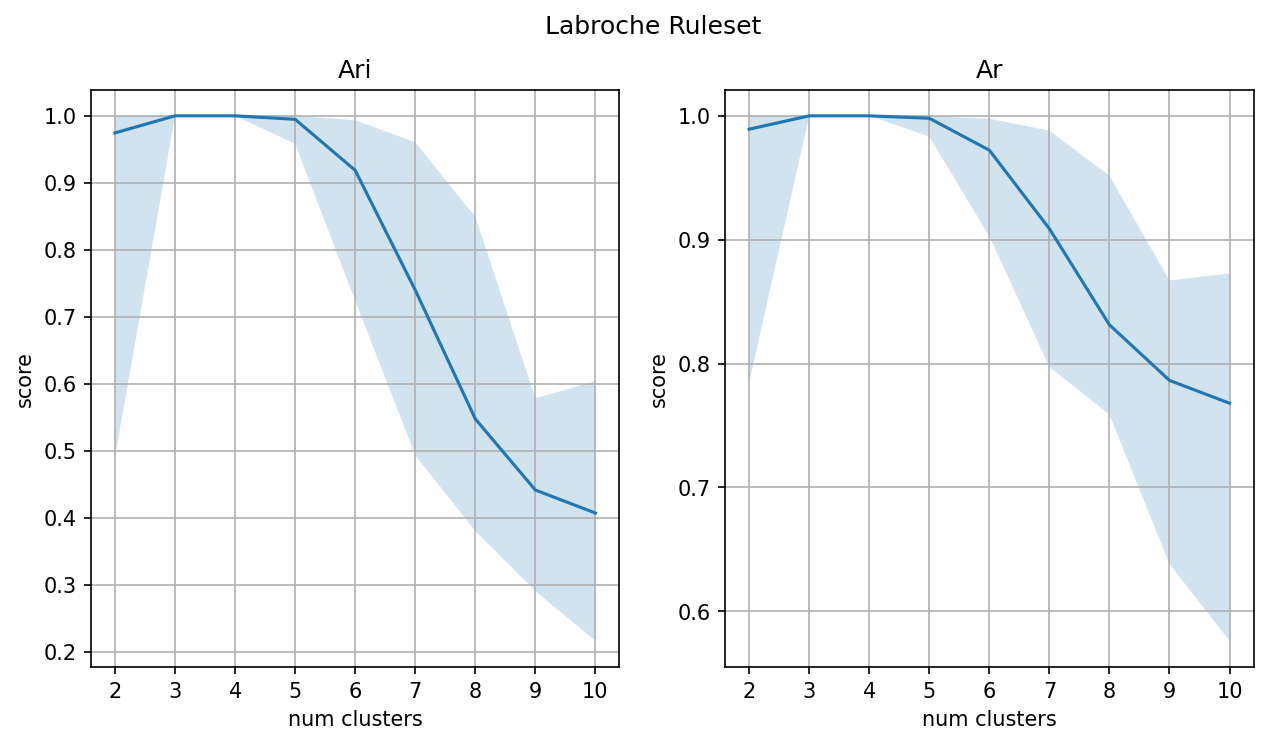

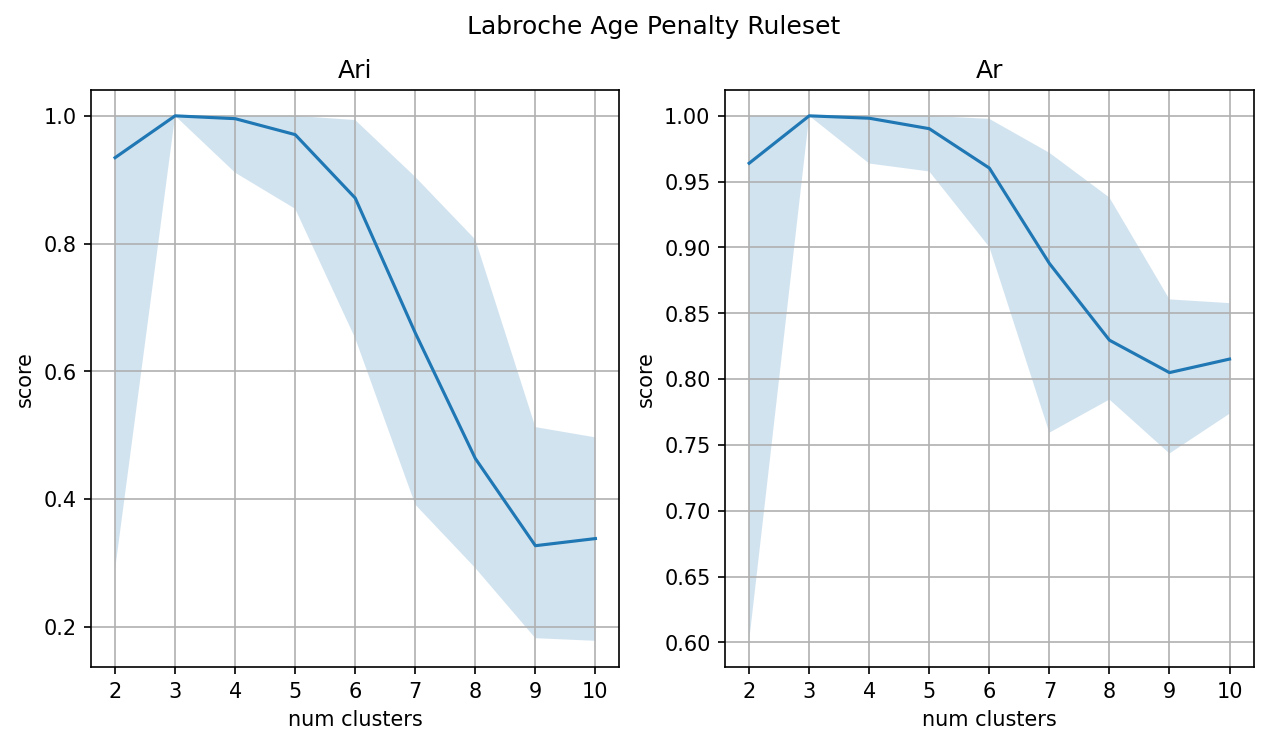

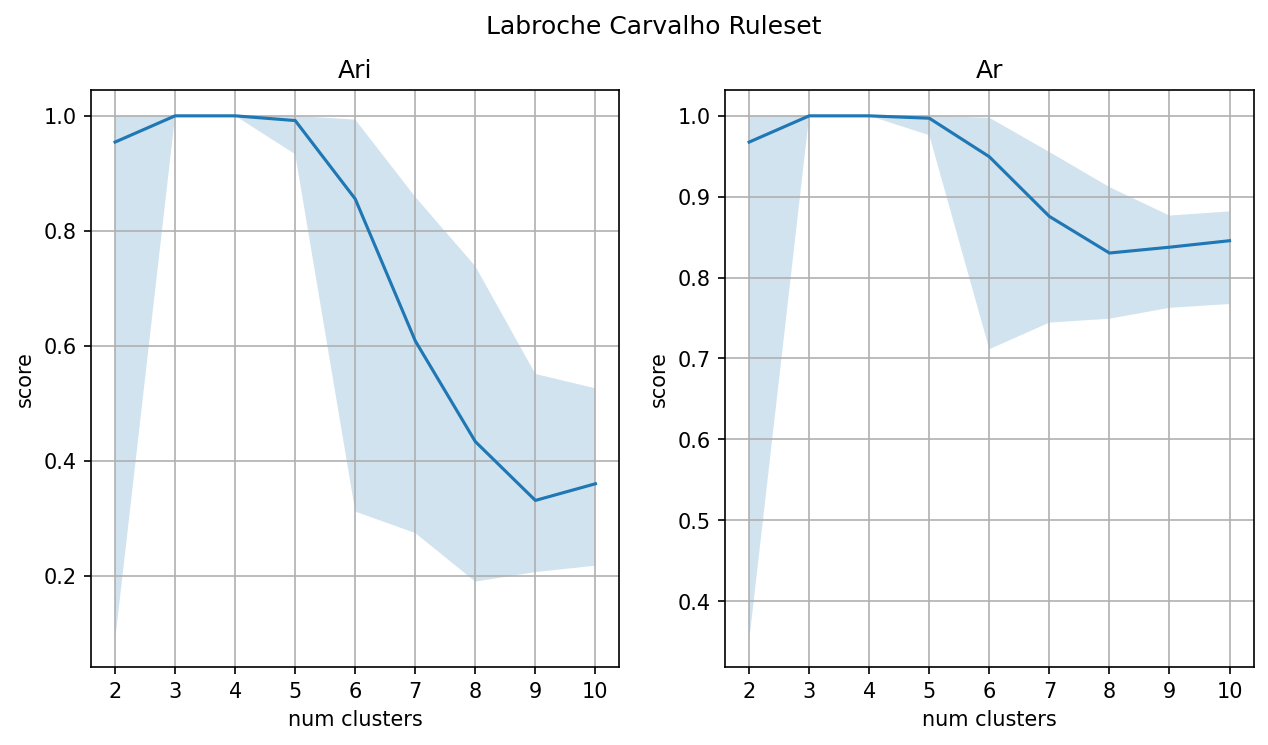

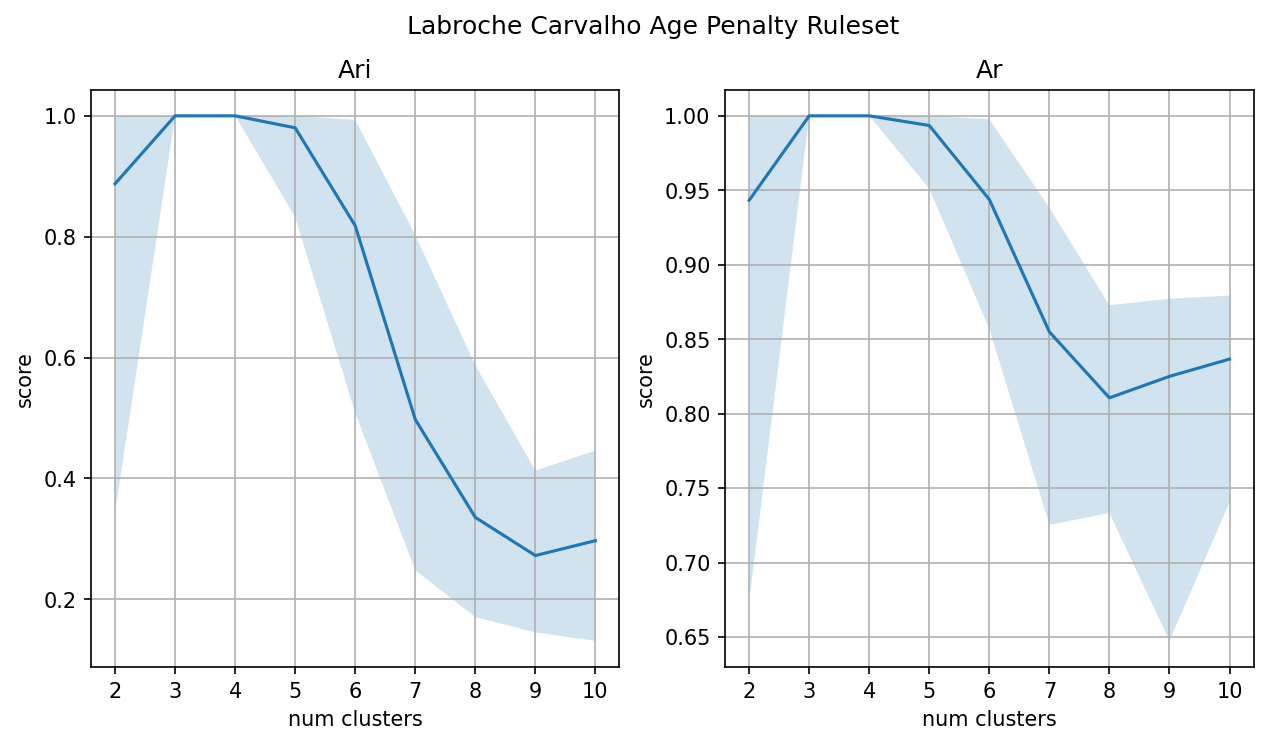

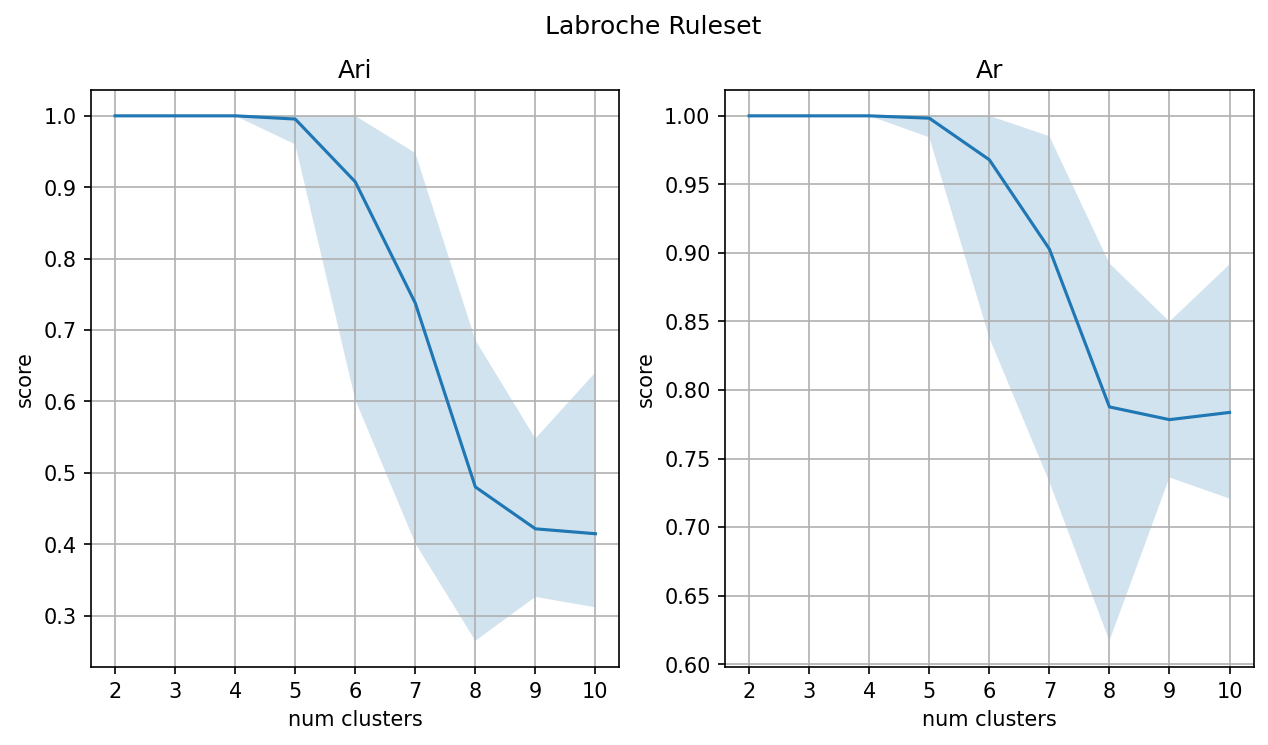

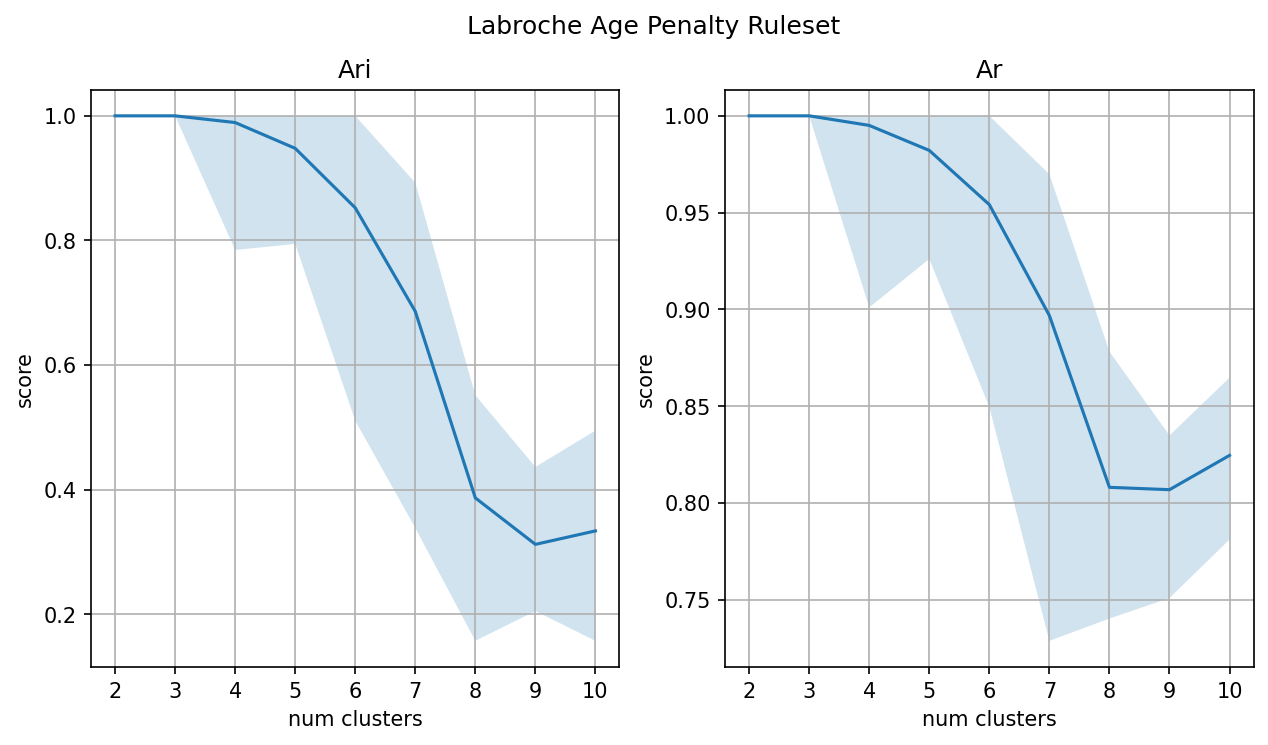

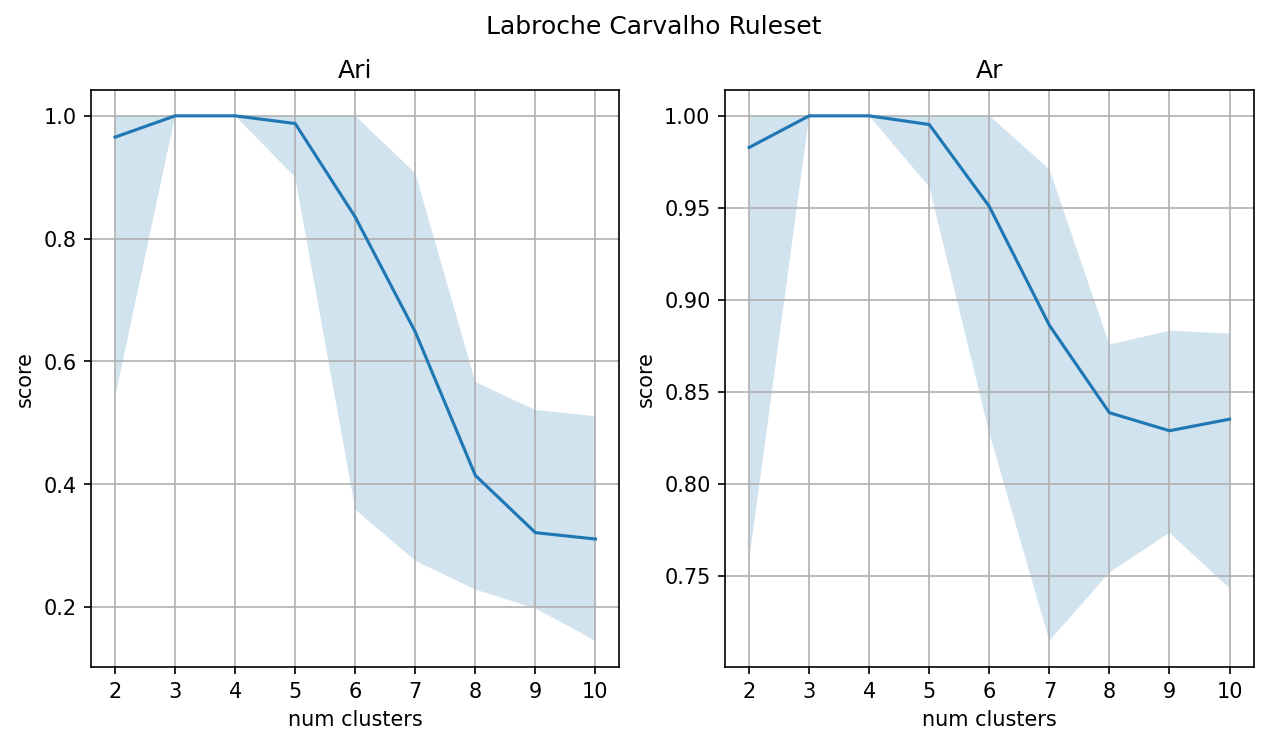

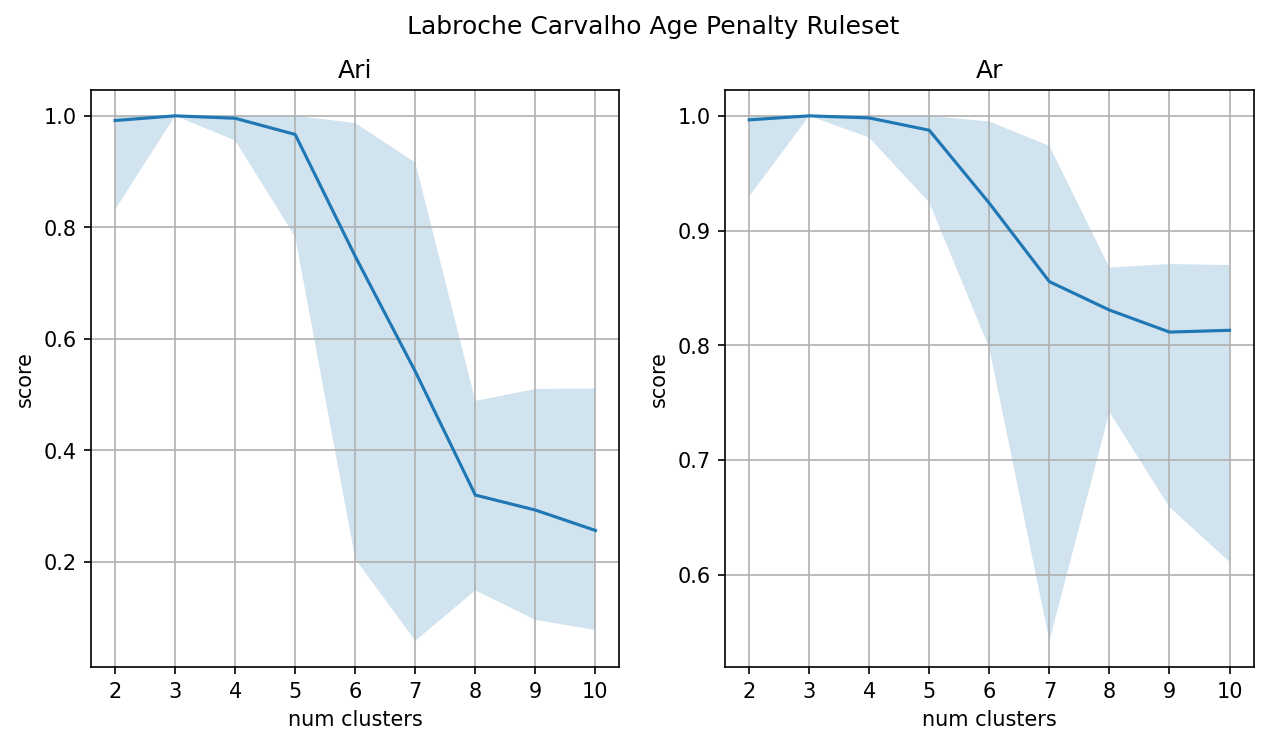

In [52]:
# Structure = (rule_to_test, rule_name, dropout)
ruleset_list = [(rules.labroche_rules(), "Labroche", False),
                (rules.labroche_rules_age_penalty(), "Labroche Age Penalty", False),
                (rules.labroche_carvalho(), "Labroche Carvalho", False),
                (rules.labroche_carvalho_age_penalty(), "Labroche Carvalho Age Penalty", False),
                (rules.labroche_rules(), "Labroche", True),
                (rules.labroche_rules_age_penalty(), "Labroche Age Penalty", True),
                (rules.labroche_carvalho(), "Labroche Carvalho", True),
                (rules.labroche_carvalho_age_penalty(), "Labroche Carvalho Age Penalty", True)]

name_list = []
mean_ari_list = []
mean_ar_list = []

for ruleset in ruleset_list:
    rule, rule_name, dropout = ruleset
    mean_ari, mean_ar = measure_ruleset(rule,rule_name,dropout)
    mean_ari_list.append(mean_ari)
    mean_ar_list.append(mean_ar)
    name_list.append(f'{rule_name.replace(" ","_")}_dropout_{dropout}')

In [2]:
import pandas as pd
import numpy as np

def build_csv(name_list, value_list,min,max,metric_type):
    columns = ['{} cluster(s)'.format(i) for i in range(min,max+1)]
    df = pd.DataFrame(columns=columns)
    for i in range(len(value_list)):
        new_row_df = pd.DataFrame([value_list[i]], columns=df.columns,index=[name_list[i]])
        df = pd.concat([df,new_row_df])
    df.to_csv(f'ruleset_metrics_{metric_type}.csv', index=True)
    return df

df_ari = build_csv(name_list, mean_ari_list,2,10,"ari")
df_ar = build_csv(name_list, mean_ar_list,2,10,"ar")

NameError: name 'name_list' is not defined

In [ ]:
df_ari

In [3]:
import pandas as pd

df_ari = pd.read_csv("ruleset_metrics_ari.csv",index_col=0)
row_means = df_ari.mean(axis=1)

# Display the result
print("\nRow Means:")
print(row_means)


Row Means:
Labroche_dropout_False                         0.780386
Labroche_Age_Penalty_dropout_False             0.728888
Labroche_Carvalho_dropout_False                0.725974
Labroche_Carvalho_Age_Penalty_dropout_False    0.676476
Labroche_dropout_True                          0.773044
Labroche_Age_Penalty_dropout_True              0.723121
Labroche_Carvalho_dropout_True                 0.720207
Labroche_Carvalho_Age_Penalty_dropout_True     0.678939
dtype: float64


Row Means:
- Labroche_dropout_False                         0.780386
- Labroche_Age_Penalty_dropout_False             0.728888
- Labroche_Carvalho_dropout_False                0.725974
- Labroche_Carvalho_Age_Penalty_dropout_False    0.676476
- Labroche_dropout_True                          0.773044
- Labroche_Age_Penalty_dropout_True              0.723121
- Labroche_Carvalho_dropout_True                 0.720207
- Labroche_Carvalho_Age_Penalty_dropout_True     0.678939


Best result per cluster:
- 2: 1.0 (Labroche_dropout_True, Labroche_Age_Penalty_dropout_True)	
- 3: 1.0 (all)
- 4: 1.0 (Labroche_dropout_False, Labroche_Carvalho_dropout_False, Labroche_Carvalho_Age_Penalty_dropout_False, Labroche_dropout_True, Labroche_Carvalho_dropout_True)
- 5: 0.995508 (Labroche_dropout_True)
- 6: 0.918541 (Labroche_dropout_False)
- 7: 0.739739 (Labroche_dropout_False)
- 8: 0.547493 (Labroche_dropout_False)
- 9: 0.441381 (Labroche_dropout_False)
- 10: 0.414740 (Labroche_dropout_True)

In [4]:
df_ari

,2 cluster(s),3 cluster(s),4 cluster(s),5 cluster(s),6 cluster(s),7 cluster(s),8 cluster(s),9 cluster(s),10 cluster(s)
Labroche_dropout_False,0.974555,1.0,1.000000,0.994751,0.918541,0.739739,0.547493,0.441381,0.407015
Labroche_Age_Penalty_dropout_False,0.934459,1.0,0.995550,0.970565,0.871186,0.660000,0.463374,0.326845,0.338013
Labroche_Carvalho_dropout_False,0.954328,1.0,1.000000,0.991781,0.855371,0.608393,0.433169,0.330848,0.359873
Labroche_Carvalho_Age_Penalty_dropout_False,0.887585,1.0,1.000000,0.980150,0.818053,0.497506,0.335551,0.272397,0.297039
Labroche_dropout_True,1.000000,1.0,1.000000,0.995508,0.907568,0.737671,0.480289,0.421618,0.414740
Labroche_Age_Penalty_dropout_True,1.000000,1.0,0.989234,0.947809,0.852314,0.686064,0.386732,0.312168,0.333771
Labroche_Carvalho_dropout_True,0.965240,1.0,1.000000,0.987436,0.835141,0.647994,0.414341,0.321063,0.310649
Labroche_Carvalho_Age_Penalty_dropout_True,0.991585,1.0,0.995627,0.966568,0.747813,0.541202,0.319363,0.292444,0.255851


# GA ruleset:
['R1', 'R2', 'R3', 'R4', 'R5_NEW'], Dropout: True, Dynamic template: False

TEST:
Rule: GA Ruleset
Dropout: True
Clusters: min(2) max(10)
Values: min(3) max(50)
Seed: 9
testing values for 2 clusters
testing values for 3 clusters
testing values for 4 clusters
testing values for 5 clusters
testing values for 6 clusters
testing values for 7 clusters
testing values for 8 clusters
testing values for 9 clusters
testing values for 10 clusters
Time to run: 7037.963496923447 seconds
True number of clusters: 5
True values per clusters: 30


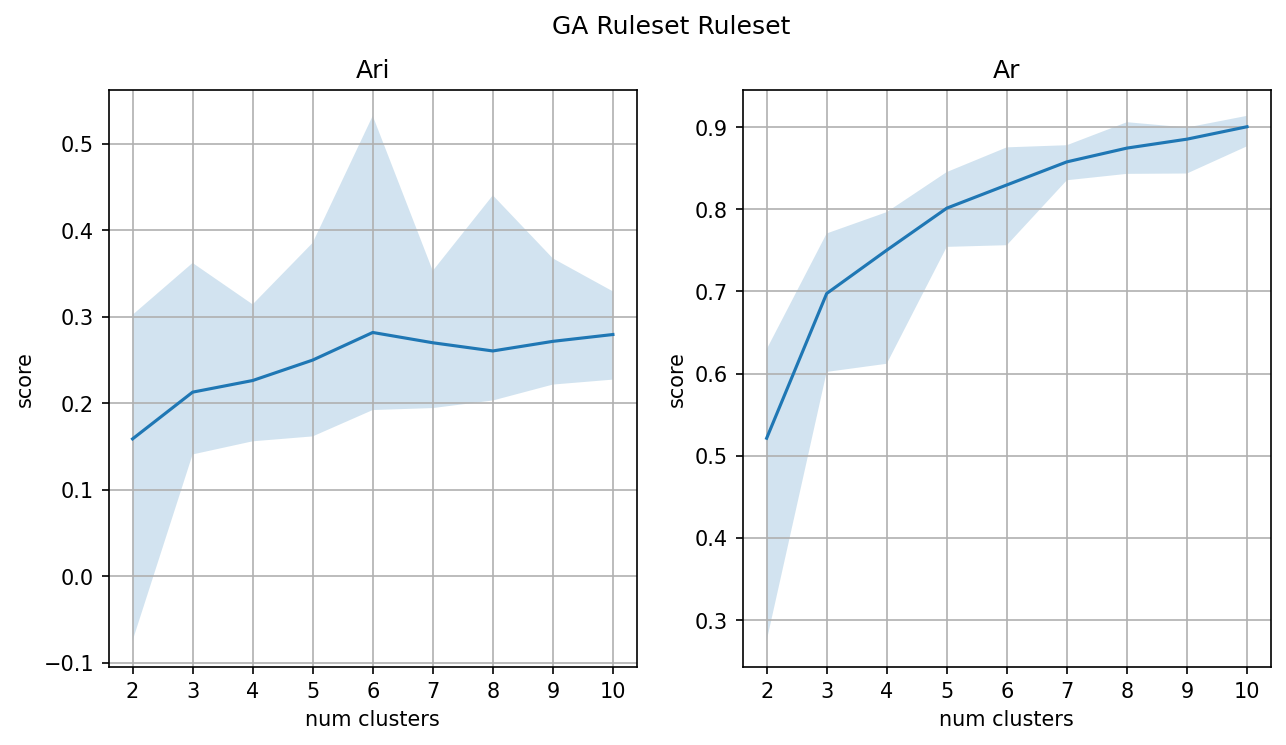

In [10]:
import sys
sys.path.append('../GA Ruleset')
import dynamic_rules
ga_rule = dynamic_rules.dynamic_rules(['R1', 'R2', 'R3', 'R4', 'R5_NEW'])
mean_ari, mean_ar = measure_ruleset(ga_rule,"GA Ruleset",dropout=True)

In [12]:
mean_ari

array([0.15878263, 0.21281425, 0.22625794, 0.24988319, 0.28179424,
       0.2699023 , 0.26042965, 0.27153935, 0.2794383 ])

In [13]:
# new_row_df = pd.DataFrame(mean_ari, columns=df_ari.columns,index=["GA_Ruleset_dropout_true"])
# df = pd.concat([df_ari,new_row_df])
df_ari

,2 cluster(s),3 cluster(s),4 cluster(s),5 cluster(s),6 cluster(s),7 cluster(s),8 cluster(s),9 cluster(s),10 cluster(s)
Labroche_dropout_False,0.974555,1.0,1.000000,0.994751,0.918541,0.739739,0.547493,0.441381,0.407015
Labroche_Age_Penalty_dropout_False,0.934459,1.0,0.995550,0.970565,0.871186,0.660000,0.463374,0.326845,0.338013
Labroche_Carvalho_dropout_False,0.954328,1.0,1.000000,0.991781,0.855371,0.608393,0.433169,0.330848,0.359873
Labroche_Carvalho_Age_Penalty_dropout_False,0.887585,1.0,1.000000,0.980150,0.818053,0.497506,0.335551,0.272397,0.297039
Labroche_dropout_True,1.000000,1.0,1.000000,0.995508,0.907568,0.737671,0.480289,0.421618,0.414740
Labroche_Age_Penalty_dropout_True,1.000000,1.0,0.989234,0.947809,0.852314,0.686064,0.386732,0.312168,0.333771
Labroche_Carvalho_dropout_True,0.965240,1.0,1.000000,0.987436,0.835141,0.647994,0.414341,0.321063,0.310649
Labroche_Carvalho_Age_Penalty_dropout_True,0.991585,1.0,0.995627,0.966568,0.747813,0.541202,0.319363,0.292444,0.255851


In [ ]:
df_ari.to_csv(f'ruleset_metrics_ari.csv', index=True)